In [1]:
import matplotlib.pyplot as plt
import statistics

%matplotlib inline

In [2]:
# this loads in everything we need from our _ren.py files
_tmp = __import__("dse-user_vars_ren")
globals().update(vars(_tmp))

In [4]:
# runs a game until we hit a terminal event
def simulate_game(tracked_stats, strat=None, debug=False):
    # playing loose and fast with global scope here because that's the expected behavior in renpy and this isn't oop
    result = False
    day = 0
    tracking = {k:[] for k in tracked_stats}

    if strat is None:
        strat = Strategy() # Strategies defined below

    reset() # resets stat store variables
    e = EventDispatchSimulator()
    
    while not result:
        day += 1
        events = e.start_day() 
        # dict with 
        # key: act, value: list of events

        choices, possible_children = e.get_choices()
        # choides is dict with
        # key: period, value: list of acts

        # possible_children is dict with
        # key: event, value: list of possible sub-events

        acts, child_acts = strat.choose(events, choices, possible_children)

        if debug:
            print(f"day {day}, { {k: events[v] for k,v in acts.items()} }, children {child_acts}")
        
        result = e.run_day(acts, child_acts)
        for stat in tracked_stats:
            tracking[stat].append(getattr(store, stat))

    return result, tracking, e.events_executed

# runs n games until they hit terminal results and then report back on all of them
def montecarlo(tracked_stats, n=100, strat=None, debug=False):
    endings = {} # dict with key: ending, value: list of number of days needed for that ending
    stats = {} # dict with key: (name of tracked stat), value: list where each element is a list of values that stat had on that day of a playthrough
    events_seen = {} # number of runs where an event was seen
    events_executed = {} # total number of times an event was seen across all runs
    for i in range(n):
        result, tracking, events = simulate_game(tracked_stats, strat=strat, debug=debug)
        runtime = len(tracking[tracked_stats[0]]) # number of turns to reach ending
        
        if result in endings.keys():
            endings[result].append(runtime)
        else:
            endings[result] = [runtime]
        for stat in tracked_stats:
            if stat not in stats.keys():
                stats[stat] = []
            
            for i in range(runtime):
                if i >= len(stats[stat]):
                    stats[stat].append([tracking[stat][i]])
                else:
                    #print(stats[stat])
                    #print(tracking[stat][i])
                    stats[stat][i].append(tracking[stat][i])
                    
        for event, tally in events.items():
            if event in events_seen:
                events_seen[event] += 1
                events_executed[event] += tally
            else:
                events_seen[event] = 1
                events_executed[event] = tally
    return endings, stats, events_seen, events_executed

In [42]:
# super class for all strategies
class Strategy(object):
    def __init__(self):
        pass
    
    # default strategy is random
    def choose(self, events, choices, possible_children={}):
        # make a random selection of acts for each period
        acts = {k: random.choice(choices[k]) for k in choices.keys()}
        child_acts = {}
        for period, act in acts.items():
            for event in events[act]:
                if event in possible_children.keys():
                    selected = random.choice(possible_children[event])
                    if selected is not None:
                        child_acts[event] = selected.name
        return acts, child_acts

    # accessory method that will be used by other strategies
    def get_deltas(self, event_list):
        # events in event list are string names
        global stats
        global store

        deltas = {}
        
        for event in event_list:
            # I wish we could do dynamic programming here but these values may change depending on game state...
            deltas[event] = {}

            # first dump stuff from store into locals
            for var in stats.keys():
                locals()[var] = getattr(store, var)

            # now run changes from event
            e = event_name_to_obj(event)
            if e is not None:
                for change in e.changes:
                    exec(change)

            # now find the changes and save them
            for var in stats.keys():
                #if locals()[var] != getattr(store, var):
                deltas[event][var] = locals()[var] - getattr(store, var)

        return deltas

# minmaxer strategy always chooses events that give the best deltas for their list of priorities
class MinMaxer(Strategy):
    def __init__(self, priorities):
        # priorities is a list of stat names
        self.priorities = priorities

    # get the best action you can take given your priorities
    def best_delta(self, event_lists, best_children={}):
        # event_lists is dict of format
        # key: action
        # value: list of events
        
        deltas = {}
        for action, event_list in event_lists.items():
            these_deltas = self.get_deltas(event_list)
            deltas[action] = {}
            for event, stats in these_deltas.items():
                for stat, change in stats.items():
                    if stat in deltas[action]:
                        deltas[action][stat] += change
                    else:
                        deltas[action][stat] = change
                if event in best_children:
                    child_event = best_children[event]
                    if child_event is not None:
                        delta_delta = self.get_deltas([child_event])
                        for stat in delta_delta[child_event].keys():
                            deltas[action][stat] += delta_delta[child_event][stat]
        
        solved = False
        prio_ind = 0
        elg_actions = list(event_lists.keys())
        
        while not solved:
            stat = self.priorities[prio_ind]
            max_val = -999
            next_elg = []

            # find everything with the best value for our current stat
            for action in elg_actions:
                delta = deltas[action]
                if delta[stat] > max_val:
                    max_val = delta[stat]
                    next_elg = [action]
                elif delta[stat] == max_val:
                    next_elg.append(action)

            # if only one item has the maximum value for the thing we're looking for
            # that's the best one
            if len(next_elg) == 1:
                #print(f"solution! {next_elg}")
                solved = True
                event = next_elg[0]
            else:
                # otherwise, defer to next stat in priorities
                prio_ind += 1
                elg_actions = next_elg

                # pick a random eligible event if all are equally qualified
                if prio_ind == len(self.priorities):
                    solved = True
                    #print(f"Picking random choice between {elg_actions}")
                    #global store
                    #print({st: getattr(store, st) for st in ["intelligence", "strength", "relaxation"]})
                    #print(deltas)
                    event = random.choice(elg_actions)

        return event
    
    def choose(self, events, choices, possible_children={}):
        child_acts = {}

        # first find best children deltas
        for period, actions in choices.items():
            for action in actions:
                for event in events[action]:
                    if event in possible_children.keys():
                        refactored = {}
                        for child in possible_children[event]:
                            if child is not None:
                                refactored[child.name] = [child.name]
                        # use the best delta function, but passing it the child name as both the "action" and the event to take
                        child_acts[event] = self.best_delta(refactored) # list of possible child events

        acts = {}

        # now that we know the best children,
        # take the simpler option and just find the action that has the best result
        for period, actions in choices.items():
            refactor = {}
            for action in actions:
                refactor[action] = events[action]

            # in a game where the results may be variable, you probably would want to run a mini monte carlo here and then account for reaction to chance
            acts[period] = self.best_delta(refactor, child_acts)
        
        return acts, child_acts

# HintFolllower is a strategy where the player always clicks on actions that show a "hint".
# because there won't always be hints (or there may be multiple hints in the same period), we need to provide a fallback strategy to follow in this case
class HintFollower(Strategy):
    def __init__(self, fallback=Strategy(), fallback_on_children=False):
        self.fallback = fallback
        self.fallback_on_children = fallback_on_children

    # given a dict of {action: [events]}, figure out which actions are giving hints
    def hinted_acts(self, events):
        acts = []
        for act, event_list in events.items():
            for event in event_list:
                e = event_name_to_obj(event)
                if e is not None and e.hintable:
                    acts.append(act)
                    break
        return acts

    def choose(self, events, choices, possible_children={}):
        acts = {}
        child_acts = {}
        fb_acts, fb_child_acts = self.fallback.choose(events, choices, possible_children)
        for period, actions in choices.items():
            elg_acts = self.hinted_acts({act:events[act] for act in actions})
            # if there's a single hint, go with that
            if len(elg_acts) == 1:
                acts[period] = elg_acts[0]
                # just assign children at random here, because they can't be hinted
                # UNLESS we want to defer to our fallback strategy on children
                for event in events[elg_acts[0]]:
                    if event in possible_children:
                        if self.fallback_on_children:
                            child_acts[event] = fb_child_acts[event]
                        else:
                            selected = random.choice(possible_children[event])
                            if selected is not None:
                                child_acts[event] = selected.name
            # if we have multiple hints, rerun the fallback choice with just the hinted actions available
            elif len(elg_acts) > 1:
                sub_acts, sub_child_acts = self.fallback.choose(events, {period: elg_acts}, possible_children)
                acts [period] = sub_acts[period]
                # check and see if we need to defer to child judgments...
                for event in events[acts[period]]:
                    if event in possible_children:
                        child_acts[event] = sub_child_acts[event]
            # otherwise... just use the fallback
            else:
                acts[period] = fb_acts[period]
                # check and see if we need to defer to child judgments...
                for event in events[acts[period]]:
                    if event in possible_children:
                        child_acts[event] = fb_child_acts[event]

        return acts, child_acts

# Now, let's run some simulations!
First, let's look at the random strategy to get an idea of baseline

In [8]:
n = 100
endings, result_stats, events_seen, events_executed = montecarlo(["intelligence","strength","relaxation"], n)

In [9]:
for end, turns in endings.items():
    print(f"{end}:\n\t{len(turns)} times ({ len(turns)/n * 100:.2f}%)\n\t{statistics.mean(turns):.2f} days average")
    if len(turns) > 1:
        print(f"\t{statistics.stdev(turns):.2f} days stdev\n\t{min(turns)}-{max(turns)} turn range")
    else:
        print(f"\t1 turn")

relaxed_ending:
	92 times (92.00%)
	19.15 days average
	6.54 days stdev
	7-35 turn range
gg_confess:
	7 times (7.00%)
	27.86 days average
	7.06 days stdev
	21-42 turn range
sg_confess:
	1 times (1.00%)
	21.00 days average
	1 turn


It makes sense that we end up at the relaxed ending the most often-- there are multiple actions in a day that can increase relaxation, where as both intelligence and strength only have a max of +10 per day.

Below is the test for how "children events" get handled.

In [10]:
print(f"locked in {events_seen['_introduction_focus']} of {n} times")

locked in 52 of 100 times


We can look at our event tallies, which show us that there's an even spread between the "default" daily events, but we only got into the glasses girl and sporty girl event chains a few times.

In [12]:
events_executed

{'cut2': 511,
 'hang': 884,
 'chat': 665,
 'introduction': 100,
 '_introduction_focus': 52,
 'study': 138,
 'exercise': 121,
 'class': 888,
 'play': 610,
 'gg_studying': 482,
 'catchme': 94,
 'borrow_pen': 62,
 'cut1': 470,
 'relaxed_ending': 92,
 'cantcatchme': 312,
 'gg_smiling': 279,
 'caughtme': 24,
 'apart': 12,
 'bookslide': 20,
 'cookies': 13,
 'gg_confess': 7,
 'together': 36,
 'pothole': 2,
 'dontsee': 2,
 'sg_confess': 1,
 'fly': 1}

Generate a rough plot that shows how stats change over time. Overlaying a scatterplot to show relative frequency of a given stat and not just the mean; note that all stats go up or down by 10 in this game (except intelligence due to the child event in the first day, which can make it go up by 5)-- in a game where stats are a little less discretized this would look less grid-like.

If you run the Monte Carlo simulations for more iterations, you may want to decrease the opacity of the scatterplot points.

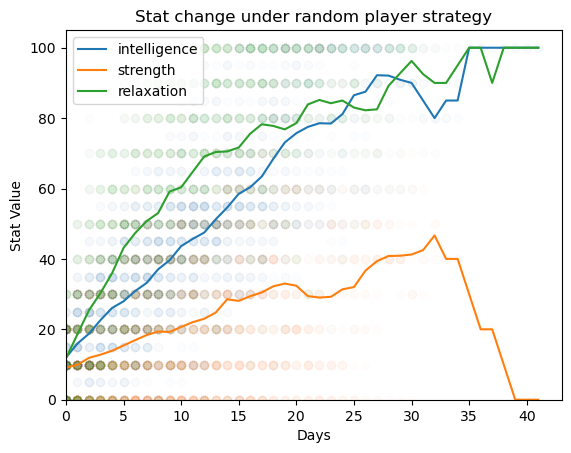

In [14]:
lines = {}
for stat, values in result_stats.items():
    vals = [statistics.mean(x) for x in values]
    sc_y = [item for sublist in values for item in sublist]
    sc_x = [item for sublist in  [[i] * len(values[i]) for i in range(len(values))] for item in sublist]
    plt.plot(
        list(range(len(vals))),
        vals,
        label = stat
    )
    plt.scatter(sc_x, sc_y, alpha=0.01)
plt.title("Stat change under random player strategy")
plt.legend(loc="upper left")
plt.xlabel("Days")
plt.ylabel("Stat Value")

plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)

plt.show()

Let's do this again, but using the minmax player who tries to maximize strength and intelligence, ignoring relaxation.

In [15]:
goodplayer = MinMaxer(["strength", "intelligence"])
endings, result_stats, events_seen, events_executed = montecarlo(["intelligence","strength","relaxation"], n=n, strat=goodplayer)

In [16]:
for end, turns in endings.items():
    print(f"{end}:\n\t{len(turns)} times ({ len(turns)/n * 100:.2f}%)\n\t{statistics.mean(turns):.2f} days average")
    if len(turns) > 1:
        print(f"\t{statistics.stdev(turns):.2f} days stdev\n\t{min(turns)}-{max(turns)} turn range")

sg_confess:
	54 times (54.00%)
	15.70 days average
	1.49 days stdev
	14-20 turn range
both_confess:
	35 times (35.00%)
	18.74 days average
	2.42 days stdev
	15-24 turn range
gg_confess:
	11 times (11.00%)
	16.73 days average
	1.85 days stdev
	15-21 turn range


In [17]:
print(f"locked in {events_seen['_introduction_focus']} of {n} times")

locked in 100 of 100 times


Notice how now we consistently get endings with at least one of the girls, and we always choose to "lock in" over the pointless non-focusing option.

In [18]:
events_executed

{'introduction': 100,
 '_introduction_focus': 100,
 'study': 200,
 'exercise': 300,
 'class': 889,
 'cut2': 342,
 'gg_studying': 299,
 'catchme': 100,
 'borrow_pen': 100,
 'caughtme': 100,
 'cantcatchme': 100,
 'gg_smiling': 591,
 'together': 399,
 'chat': 303,
 'hang': 255,
 'fly': 257,
 'pothole': 99,
 'dontsee': 187,
 'sg_confess': 54,
 'bookslide': 87,
 'cookies': 56,
 'both_confess': 35,
 'gg_confess': 11}

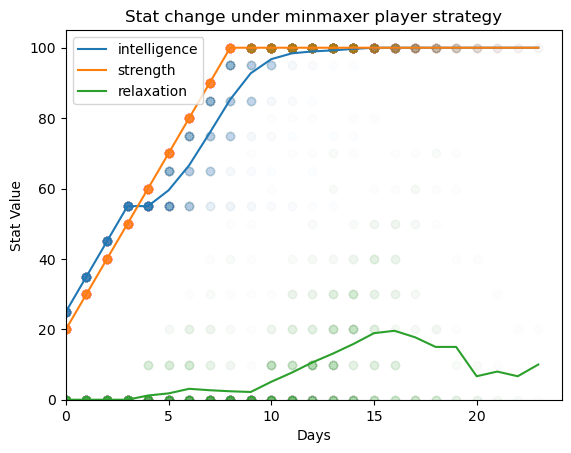

In [19]:
lines = {}
for stat, values in result_stats.items():
    vals = [statistics.mean(x) for x in values]
    sc_y = [item for sublist in values for item in sublist]
    sc_x = [item for sublist in  [[i] * len(values[i]) for i in range(len(values))] for item in sublist]
    plt.plot(
        list(range(len(vals))),
        vals,
        label = stat
    )
    plt.scatter(sc_x, sc_y, alpha=0.01)
plt.title("Stat change under minmaxer player strategy")
plt.legend(loc="upper left")
plt.xlabel("Days")
plt.ylabel("Stat Value")

plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)

plt.show()

Now, this strategy isn't entirely deterministic because, depending on where we are in the event chains for the glasses and sporty girls, sometimes they don't actually increase our stats-- so progressing the event and chilling out look like equally appealing options to this strategy.

Note that minmaxer strategy assumes that the player knows what they payoffs for each action are. To simulate a player who is still learning the ropes, you may want to employ a strategy that samples between `Strategy()` and `MinMaxer()` at some fixed rate $p$.

And last, we have the Hint Follower strategy, which leverages the "hint" system added to the roguelike fork of DSE. This simulates a player that will always click a hilighted option (if present), but otherwise will just fall back to some other strategy-- first, this strategy will be random.

In [31]:
endings, result_stats, events_seen, events_executed = montecarlo(["intelligence","strength","relaxation"], n=n, strat=HintFollower())

In [32]:
for end, turns in endings.items():
    print(f"{end}:\n\t{len(turns)} times ({ len(turns)/n * 100:.2f}%)\n\t{statistics.mean(turns):.2f} days average")
    if len(turns) > 1:
        print(f"\t{statistics.stdev(turns):.2f} days stdev\n\t{min(turns)}-{max(turns)} turn range")

relaxed_ending:
	75 times (75.00%)
	14.83 days average
	5.07 days stdev
	5-28 turn range
sg_confess:
	13 times (13.00%)
	22.00 days average
	4.60 days stdev
	16-33 turn range
gg_confess:
	11 times (11.00%)
	25.73 days average
	4.71 days stdev
	21-37 turn range
both_confess:
	1 times (1.00%)
	29.00 days average


We still see the relaxed ending a lot, but note that this player reaches the confession endings much more often than when truly random.

Interestingly, this strategy makes all three stats increase at roughly equal rates.

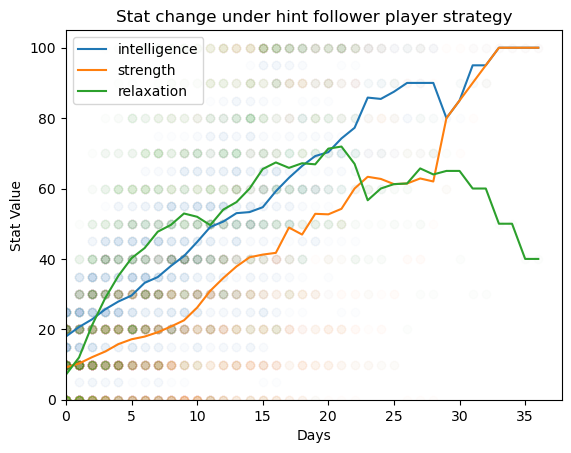

In [33]:
lines = {}
for stat, values in result_stats.items():
    vals = [statistics.mean(x) for x in values]
    sc_y = [item for sublist in values for item in sublist]
    sc_x = [item for sublist in  [[i] * len(values[i]) for i in range(len(values))] for item in sublist]
    plt.plot(
        list(range(len(vals))),
        vals,
        label = stat
    )
    plt.scatter(sc_x, sc_y, alpha=0.01)
plt.title("Stat change under hint follower player strategy")
plt.legend(loc="upper left")
plt.xlabel("Days")
plt.ylabel("Stat Value")

plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)

plt.show()

Now, for the last (and most deterministic) strategy: a hintfollowing player who defers to the minmaxer strategy that we outlined earlier.

In [43]:
endings, result_stats, events_seen, events_executed = montecarlo(["intelligence","strength","relaxation"], n=n, strat=HintFollower(fallback=goodplayer, fallback_on_children=True))

In [44]:
print(f"locked in {events_seen['_introduction_focus']} of {n} times")

locked in 100 of 100 times


In [45]:
for end, turns in endings.items():
    print(f"{end}:\n\t{len(turns)} times ({ len(turns)/n * 100:.2f}%)\n\t{statistics.mean(turns):.2f} days average")
    if len(turns) > 1:
        print(f"\t{statistics.stdev(turns):.2f} days stdev\n\t{min(turns)}-{max(turns)} turn range")

sg_confess:
	52 times (52.00%)
	14.00 days average
	0.00 days stdev
	14-14 turn range
gg_confess:
	28 times (28.00%)
	15.00 days average
	0.00 days stdev
	15-15 turn range
both_confess:
	20 times (20.00%)
	15.00 days average
	0.00 days stdev
	15-15 turn range


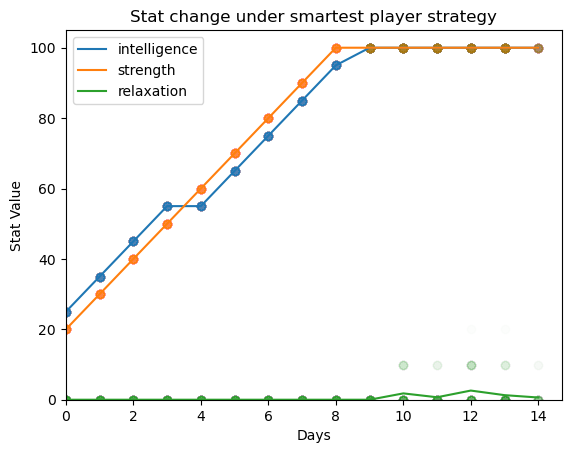

In [46]:
lines = {}
for stat, values in result_stats.items():
    vals = [statistics.mean(x) for x in values]
    sc_y = [item for sublist in values for item in sublist]
    sc_x = [item for sublist in  [[i] * len(values[i]) for i in range(len(values))] for item in sublist]
    plt.plot(
        list(range(len(vals))),
        vals,
        label = stat
    )
    plt.scatter(sc_x, sc_y, alpha=0.01)
plt.title("Stat change under smartest player strategy")
plt.legend(loc="upper left")
plt.xlabel("Days")
plt.ylabel("Stat Value")

plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)

plt.show()

See how there is no variation in stats across different playthroughs until both intelligence and strength get maxed out? That's because we're following the exact same course of actions in every run, unlike the minmaxer strategy that gets lost for a bit partway through the romance event chains. There's still a little bit of variance from random selections made when at the very end of all of the event chains, but it's nice to know that you can get to this "best strategy" by deriving what actions to take from the direct effects that each event has on gamestate.